In [1]:
# ----------------- IMPORTS LIBRARIES -------------------------- #
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz as graphviz
from sklearn import tree, feature_selection, linear_model, model_selection, metrics, ensemble
from sklearn.feature_selection import RFECV
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from six import StringIO 
from IPython.display import Image 
from pydot import graph_from_dot_data

import keras
import keras.backend as K
from keras.layers import Input
from keras.models import Model

from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
# -------------------------- FUNCTIONS -------------------------- #

# FUNCTION TO RETURN THE DATASET FROM ITS URL
def getDataSet(df_path):
    df_initial = pd.read_csv(df_path, encoding= 'unicode_escape')
    return df_initial

# FUNCTION TO REMOVES SPECIAL CHARACTERS, SPACES AND SYMBOLS
#   CHANGES SPACE FOR '_'
def changeVariablesName(df):
    for column in df:
        oldColumnName = str(column)
        newColumnName = ""
        for character in oldColumnName:
            if character.isspace():
                newColumnName += '_'
            else:
                if character.isalnum():
                    newColumnName += character
        df.rename(columns={oldColumnName : newColumnName}, inplace = True)

    return df

# FUNCTION TO CALCULATE ACCUACY 
def getAccuracy(y_test, y_pred): 
    return accuracy_score(y_test,y_pred) * 100

# FUNCTION TO PRINT MODELS IN PGN FORMAT
def getPrintableModel(model, feature_names):

    classes = ['Positive', 'Negative']

    dot_data = StringIO()

    tree.export_graphviz(model, out_file = dot_data, feature_names = feature_names, class_names = classes, filled=True)

    (graph, ) = graph_from_dot_data(dot_data.getvalue())

    return graph.create_png()

#FUNCTION TO PRINT GRAPHS
def printGraph(values, x_label, y_label):
    y_pos = np.arange(len(x_label))

    plt.bar(y_pos, values, align='center', alpha=1)
    plt.xticks(y_pos, x_label)
    plt.ylabel(y_label)
    plt.show()

# FUNCTION TO PRINT ACCURACY OF THE TRAINING AND TEST
def printAccuracy(model_dataSet, x_test, x_train, y_test, y_train):
    print("Train accuracy:", model_dataSet.score(x_train, y_train))
    print("Test accuracy:", model_dataSet.score(x_test, y_test))

    # classification report on test data
    y_reg_pred = model_dataSet.predict(x_test)
    print(classification_report(y_test, y_reg_pred))

# FUNCTION TO PRINT THE COLUMNS WITH NaN VALUES
def printNanColumns(dataSet):
    nan_columns = []
    nan_values = []

    for column in dataSet.columns:
        nan_columns.append(column)
        nan_values.append(dataSet[column].isnull().sum())

    values = nan_values
    printGraph(values, nan_columns, 'Number of Nan values')

# FUNCTION TO PRINT THE PERCENTUAL OF POSITIVE AND NEGATIVE CASES
def printPositiveAndNegativeCases(porcentual_positive, porcentual_negative):
    values = [porcentual_positive, porcentual_negative]
    x_label = ['Positive', 'Negative']
    y_label = 'Percentual of positive and negative cases'
    printGraph(values, x_label, y_label)

## Task 1: Preparation of data

In [3]:
# FIRST AT ALL IT IS ASSIGNED IN A VARIABLE THE ADDRESS OF THE DATASET GIVEN
covid_hospitalization_sample_path = "covid_hospitalization_sample.csv"

# THE VARIABLE ASSIGNED ABOVE IS USED TO READ THE DATASET PRESENTED IN THE ASSESSIMENT.
df_covid_hospitalization = getDataSet(covid_hospitalization_sample_path)

# INITIALLY THE DATSET PRESENTS DATA DIVIDED IN SIX GROUPS SUCH AS 
   # blood test, Liver kidney gas test, Urine test, Bone marrow cells test, and Influenza rapid.
     #  HOWEVER, ITS REQUIRED TO BE USED JUST DATA FROM THE GROUPS regular bloo test and influenza rapid test.
       # IN ADDITION PatientID, Patient age quantile, SARS-Cov-2 exam result, Patient admitted to regular ward, Patient admitted to                 semiintensive unit, Patient admitted to intensive care unit AND Patient ID
       #### THESE FIELDS ARE SO ASSIGNED IN THE DATASET ####
df_regular_blood_test_and_influenza_rapid_test = df_covid_hospitalization[{'Patient ID'
                                                                         , 'Patient age quantile'
                                                                         , 'SARS-Cov-2 exam result'
                                                                         , 'Proteina C reativa'
                                                                         , 'Neutrophils'
                                                                         , 'Mean platelet volume'
                                                                         , 'Monocytes'
                                                                         , 'Red blood cell distribution width'
                                                                         , 'Red blood Cells'
                                                                         , 'Platelets'
                                                                         , 'Eosinophils'
                                                                         , 'Basophils'
                                                                         , 'Leukocytes'
                                                                         , 'Mean corpuscular hemoglobin'
                                                                         , 'Mean corpuscular volume'
                                                                         , 'Mean corpuscular hemoglobin concentration'
                                                                         , 'Lymphocytes'
                                                                         , 'Hemoglobin'
                                                                         , 'Hematocrit'
                                                                         , 'Influenza B rapid test'
                                                                         , 'Influenza A rapid test'}]

# IN ORDER TO MAKE THE NAME OF THE COLUMNS EASIER UNDERSTOOD IT WAS CREATED AN PATTERN TO THOSE.
 # IN THIS PATTERN IT IS ELIMINATED THE SPECIAL CHARACTERS AND SYMBOLS. BESIDES CHANGES SPACES FOR '_'.
df_regular_blood_test_and_influenza_rapid_test = changeVariablesName(df_regular_blood_test_and_influenza_rapid_test)

# HOW THE COLUMNS ARE NAMED THEN IS SHOWN BELLOW.
df_regular_blood_test_and_influenza_rapid_test.head()

,Mean_platelet_volume,Monocytes,Influenza_B_rapid_test,Mean_corpuscular_volume,Influenza_A_rapid_test,Leukocytes,Basophils,Eosinophils,Neutrophils,Red_blood_cell_distribution_width,...,Proteina_C_reativa,Patient_ID,Patient_age_quantile,Hematocrit,Mean_corpuscular_hemoglobin_concentration,Hemoglobin,Lymphocytes,Red_blood_Cells,SARSCov2_exam_result,Mean_corpuscular_hemoglobin
0,NaN,NaN,positive,NaN,negative,NaN,NaN,NaN,NaN,NaN,...,NaN,9abc76405794c6d,9,NaN,NaN,NaN,NaN,NaN,negative,NaN
1,0.010677,1.250496,positive,0.086074,negative,-0.653951,0.081693,-0.624811,-0.356851,-0.182790,...,-0.316791,01d324f278f3101,16,0.671398,-1.249524,0.290940,0.173372,0.525133,negative,-0.501356
2,NaN,NaN,positive,NaN,negative,NaN,NaN,NaN,NaN,NaN,...,NaN,b2fb9312efbadc1,9,NaN,NaN,NaN,NaN,NaN,negative,NaN
3,-0.438097,-1.270772,positive,-1.255906,negative,-0.080696,-1.140144,-0.835508,NaN,0.613318,...,-0.342622,eb5ef46a892698f,0,-0.152590,-1.249524,-0.460932,3.764100,0.472242,negative,-1.651331
4,NaN,NaN,positive,NaN,negative,NaN,NaN,NaN,NaN,NaN,...,NaN,a713345aef928fa,10,NaN,NaN,NaN,NaN,NaN,negative,NaN


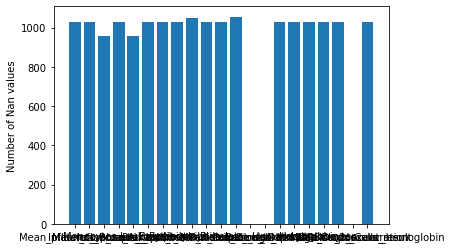

In [4]:
# NEXT STEP WAS TO PROT A GRAPH WITH THE NaN VALUES.
printNanColumns(df_regular_blood_test_and_influenza_rapid_test)
# AS SHOWS IN THE GRAPH ABOVE THERE ARE MANY NaN VALUES IN THE DATA GIVEN
 # TO THESE COLUMNS THE VALUE ZERO SHOULD HAVE SOME MEANING WHAT SHOULD AFFECT THE RESULTS OF THE PREDICTIONS

####  AND SO THE IT WAS DECIDED TO REMOVE THESE VALUES FROM THE DATASET.
df_regular_blood_test_and_influenza_rapid_test.fillna(0, inplace = True)
#df_regular_blood_test_and_influenza_rapid_test = df_regular_blood_test_and_influenza_rapid_test.dropna()

In [5]:
# IT WAS ALSO CHECKED ALL THE COLUMNS IN ORDER TO CHECK WHETHER THERE IS/ARE DESCRITIVE(S) FIELD(S)
df_regular_blood_test_and_influenza_rapid_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 21 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Mean_platelet_volume                       1230 non-null   float64
 1   Monocytes                                  1230 non-null   float64
 2   Influenza_B_rapid_test                     1230 non-null   object 
 3   Mean_corpuscular_volume                    1230 non-null   float64
 4   Influenza_A_rapid_test                     1230 non-null   object 
 5   Leukocytes                                 1230 non-null   float64
 6   Basophils                                  1230 non-null   float64
 7   Eosinophils                                1230 non-null   float64
 8   Neutrophils                                1230 non-null   float64
 9   Red_blood_cell_distribution_width          1230 non-null   float64
 10  Platelets               

In [6]:
# AND SO, IN ORDER TO WORK JUST WITH NUMERIC VALUES IT IS CHANGED THE VALUES OF 
 # THESE DESCRITIVE COLUMNS (SARS-Cov-2 exam result, Influenza_B_rapid_test AND Influenza_A_rapid_test) TO NUMERIC.
  # THE RULE FOR THE VALUES OF THE THIS COLUMN IS 1 WHEN NEGATIVE AND 0 WHEN POSITIVE.

# ****** SARSCov2_exam_result ******
df_regular_blood_test_and_influenza_rapid_test['SARSCov2_exam_result'] = pd.get_dummies(df_regular_blood_test_and_influenza_rapid_test['SARSCov2_exam_result'],  drop_first=True)

# ****** Influenza_A_rapid_test ******
df_regular_blood_test_and_influenza_rapid_test['Influenza_A_rapid_test'] = pd.get_dummies(df_regular_blood_test_and_influenza_rapid_test['Influenza_A_rapid_test'])

# ****** Influenza_B_rapid_test ******
df_regular_blood_test_and_influenza_rapid_test['Influenza_B_rapid_test'] = pd.get_dummies(df_regular_blood_test_and_influenza_rapid_test['Influenza_B_rapid_test'])

# THE VALUES OF THESE COLUMNS WERE THEN CHANGED AS SHOWED.
df_regular_blood_test_and_influenza_rapid_test[{"SARSCov2_exam_result", "Influenza_A_rapid_test", "Influenza_B_rapid_test"}].head()

,Influenza_A_rapid_test,Influenza_B_rapid_test,SARSCov2_exam_result
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


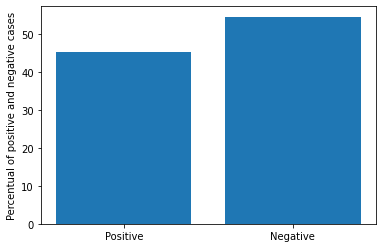

In [7]:
# THE NEXT STEP WAS TO PROT A GRAPH WITH THE PERCENTUAL OF POSITVE AND NEGATIVE CASES IS CALCULATED AND SHOWED IN A GRAPH AS SHOWED
qtde_total = df_regular_blood_test_and_influenza_rapid_test.groupby("Patient_ID")['Patient_ID'].count().sum()

qtde_negative = df_regular_blood_test_and_influenza_rapid_test[df_regular_blood_test_and_influenza_rapid_test["SARSCov2_exam_result"]
==0].groupby("Patient_ID")['Patient_ID'].count().sum()

qtde_positive = df_regular_blood_test_and_influenza_rapid_test[df_regular_blood_test_and_influenza_rapid_test["SARSCov2_exam_result"]==1].groupby("Patient_ID")['Patient_ID'].count().sum()

porcentual_negative = (qtde_negative / qtde_total) * 100
porcentual_positive = ( qtde_positive/ qtde_total) * 100

printPositiveAndNegativeCases(porcentual_positive, porcentual_negative)

In [8]:
# THIS VALUES ARE JUST AN INITIAL VISUALIZATION OF THE DATA, WHICH WAS USED THE COLUMN SARSCov2_exam_result TO CALCULATE THOSE.
 # THE FIELD SARSCov2_exam_result IS THE ONE WE WANT TO UNDERSTAND AND PREDICT, SO THIS FIELD IS REPLACED BY THE COLUMN TARGET
df_regular_blood_test_and_influenza_rapid_test["target"] = df_regular_blood_test_and_influenza_rapid_test["SARSCov2_exam_result"]
df_regular_blood_test_and_influenza_rapid_test = df_regular_blood_test_and_influenza_rapid_test.drop(["SARSCov2_exam_result"], axis = 1)

# AFTER IT THE FIELD Patient_ID IS DELETED, BECAUSE THIS FIELD NO LONGER WILL BE USED IN THE PROJECT
df_regular_blood_test_and_influenza_rapid_test = df_regular_blood_test_and_influenza_rapid_test.drop(["Patient_ID"], axis = 1)

In [9]:
# FITTS X AND Y

feature_names = df_regular_blood_test_and_influenza_rapid_test.drop("target", axis=1).columns.tolist()

x = pd.DataFrame(df_regular_blood_test_and_influenza_rapid_test, columns = feature_names).values
y = df_regular_blood_test_and_influenza_rapid_test["target"].values


random_state = 10

# SPLITTS THE DATASET INTO TRAIN AND TEST (25% FOR TEST AND 80% TRAINING)
 # ASSIGNS random_state TO MAKE THE TRAIN DATA CONSTANT FOR EVERY RUN
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = random_state)

## Task 2: Predictive modeling using Decision Tree 

### 2.1. Build a decision tree using the default setting

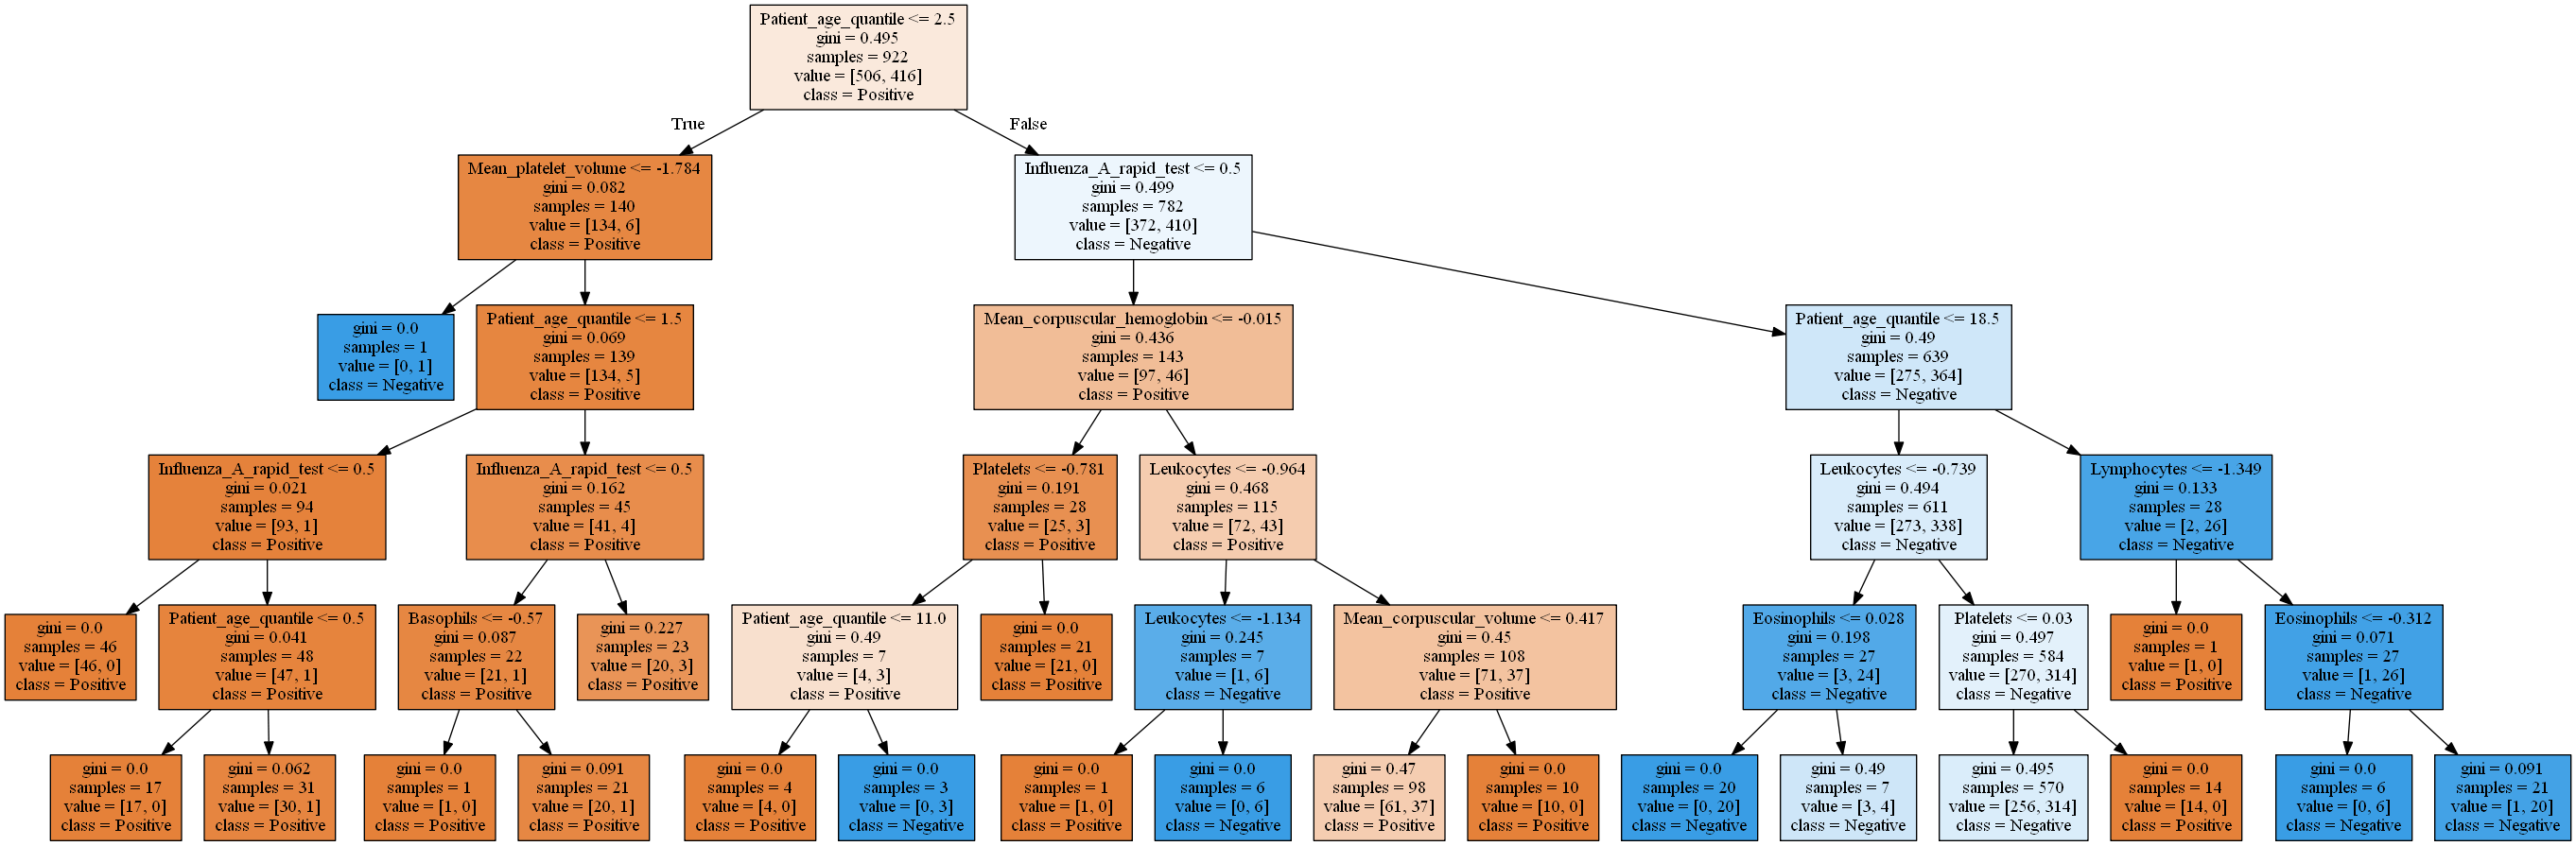

In [10]:
# CREATES AND TRAIN AN INSTANCE OF THE DecisionTreeClassifer CLASS
 # CRITERION = "gini" (DEFAULT)
 # max_depth = 2 (AVOID OVERFITTING)
 # min_samples_split = 2 (DEFAULT)
 # min_samples_leaf = 1 (DEFAULT)
model = DecisionTreeClassifier(max_depth = 5)
model.fit(x_train, y_train)

# PRINTS THE DERIVARION TREE PRODUCED BY THE MODEL
graph = getPrintableModel(model, feature_names)
Image(graph)

In [11]:
# PRINT THE CLASSIFICATION ACCURACY OF TRAINING AND TEST
#printAccuracy(x_test)

### 2.2. Build another decision tree tuned with GridSearchCV

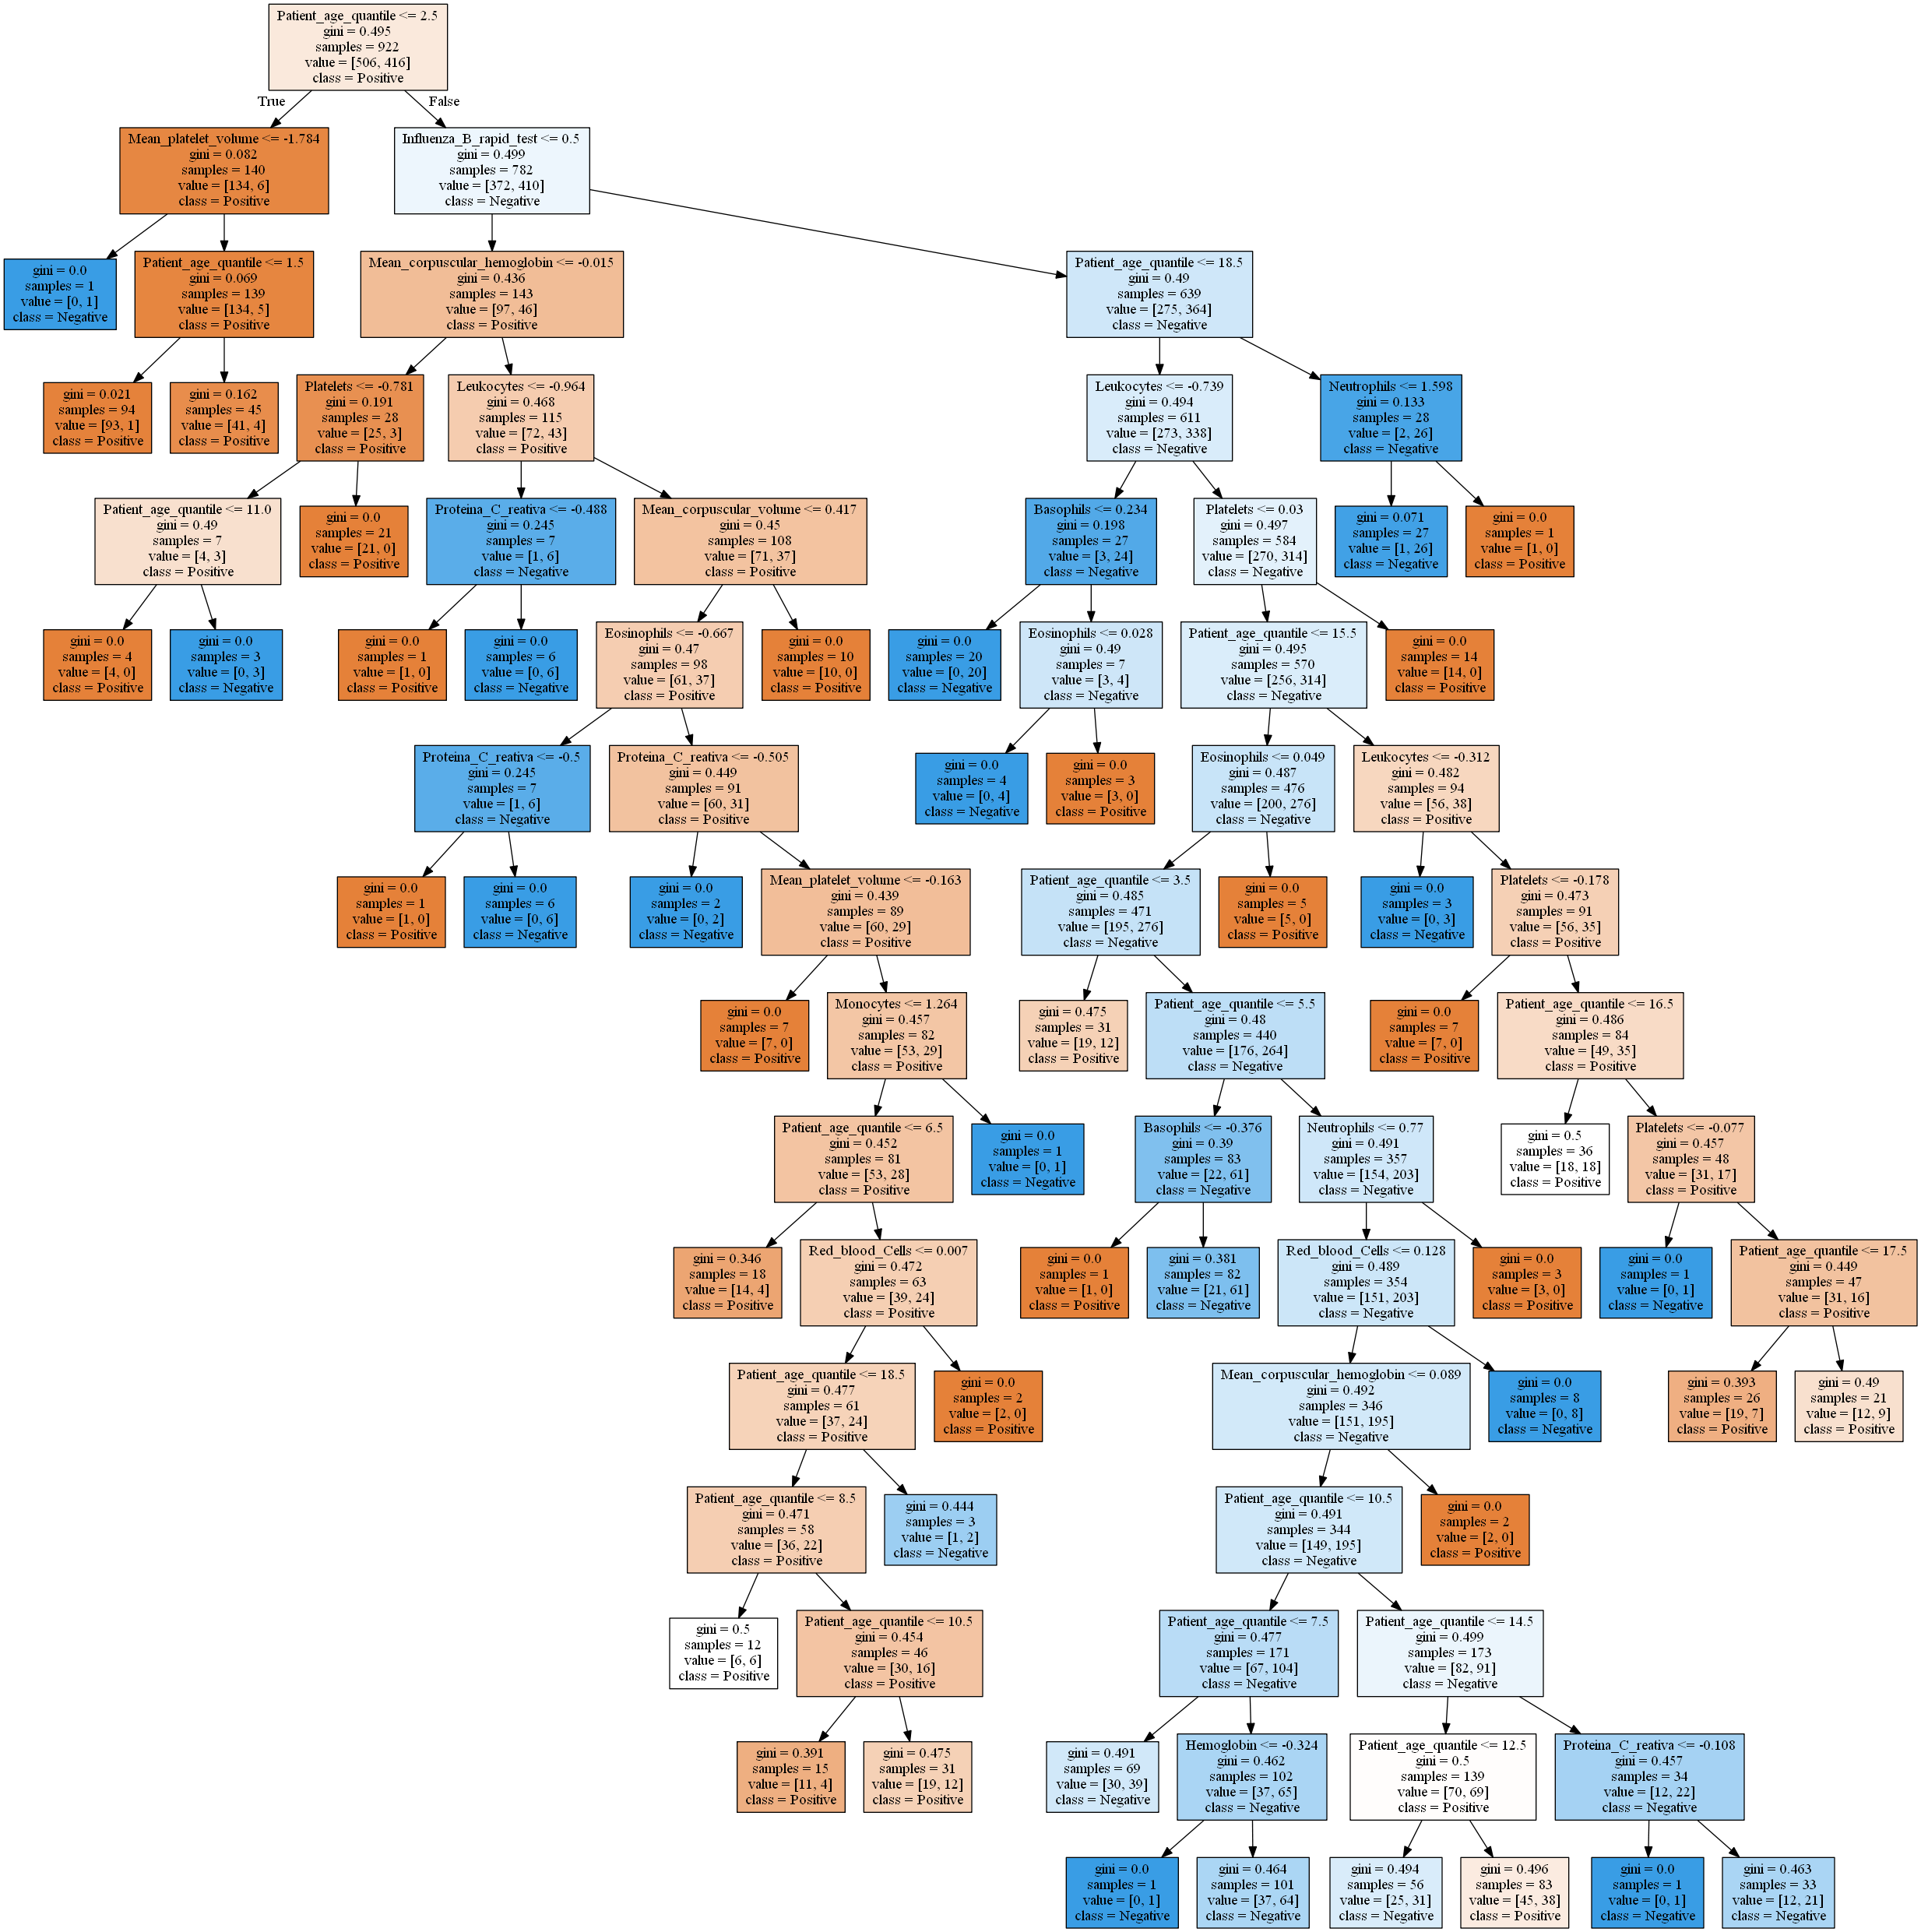

In [12]:
params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}

grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=random_state), params, cv=10)
grid_search_cv.fit(x_train, y_train)

# PRINTS THE DERIVARION TREE PRODUCED BY THE MODEL
graph = getPrintableModel(grid_search_cv.best_estimator_, feature_names)
Image(graph)

#printAccuracy(x_test)

## Task 3: Predictive modeling using Regression

### 3.1. Build a regression model using the default regression method with all inputs

In [13]:
    # ------------------------------- b. Name the regression function used ------------------------------- #
    
# THE FIRST STEP IN THIS SECTION WAS TO DECISE THE MODEL TO BE USED FOR REGRESSION, WHICH WAS AGREED TO USE THE logistic model.
 # logistic model IS USED TO MODEL THE PROBABILITY OF CLASSES SUCH AS PASS/FAIL, WHAT IS APPLICABLE TO OUR MODEL, BECAUSE IT
  # EVALUATES POSITIVE/NEGATIVE RESULTS OF SOMEONE FOR CORONAVIRUS.
model = LogisticRegression(random_state=random_state)
model.fit(x_train, y_train)

#--------------------------------- f. What is classification accuracy on training and test datasets? ---------------------------------#
printAccuracy(model, x_test, x_train, y_test, y_train)

Train accuracy: 0.6052060737527115
Test accuracy: 0.5681818181818182
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       166
           1       0.53      0.53      0.53       142

    accuracy                           0.57       308
   macro avg       0.57      0.57      0.57       308
weighted avg       0.57      0.57      0.57       308



In [14]:
# USING THE SAME MODEL ABOVE IT WAS TURNED IN GridSearchCV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

# use all cores to tune logistic regression with C parameter
grid = GridSearchCV(param_grid=params, estimator=model, return_train_score=True, cv=random_state)
grid.fit(x_train, y_train)

#--------------------------------- f. What is classification accuracy on training and test datasets? ---------------------------------#
printAccuracy(grid, x_test, x_train, y_test, y_train)

Train accuracy: 0.6030368763557483
Test accuracy: 0.564935064935065
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       166
           1       0.53      0.52      0.52       142

    accuracy                           0.56       308
   macro avg       0.56      0.56      0.56       308
weighted avg       0.56      0.56      0.56       308



In [15]:
# ------------------------------- a. Explain why did you choose that model? ------------------------------- #

# AS SHOWED BY THE RESULTS ABOVE THE FIRST MODEL LogisticRegression, WHICH IS NOT APPLYED GridSearchCV PERFORMANCED BETTER
 # AND SO THAT IS THE ONE USED IN THIS SECTION.

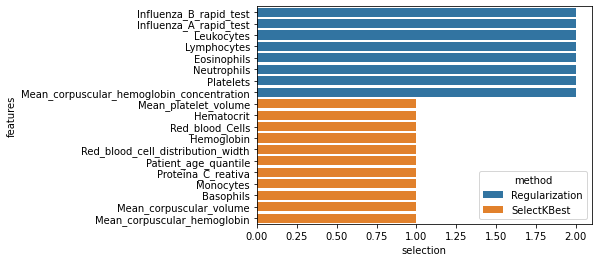

In [16]:
# IN ORDER TO GET THE TOP-5 IMPORTANT VARIABLES IN THE MODEL THE SelectKBest WAS APPLIED
 # SelectKBest SCORES THE FEATURES(x_train) AGAINST THE TARGET VARIBLE (y_train) USING A FUNCTION TO RETURNS THE
  # TOP-K IMPORTANT VARIABLES (K=19). IN THIS CASE AS THE VALUES OF THE FEATURES ARE CONTINUOS IT WAS DECIDED TO
   # USE THE FUNCTION linear regression (f_regression)
selector = feature_selection.SelectKBest(score_func=feature_selection.f_regression, k=19).fit(x_train, y_train)
best_features = np.asarray(feature_names)[selector.get_support()]

# ---------------  c. Did you apply standardization of variables? Why would you normalise the variables for regression mining? --------#
 # -------------------------------------------- d. Report on which variables are included -------------------------------------------- #

# TO PUT ALL THE VARIABLES VARIABLES AT THE SAME LEVEL scale (standardization) IT WAS IN THE APPLYED THE RIDGE REGRESSION IN ALL
 #  VARIABLES OF THE DATASET max_features=19.
# THE normalise OF THE DATA IS IMPORTANT TO AVOID Multicollinearity PROBLEM WHAT CAN PRODUCE IMPRECISE COEFFICIENT AND SO MAKES HARDER   # TO CHOOSE THE CORRENT MODEL.
selector = feature_selection.SelectFromModel(estimator=model, max_features=19).fit(x_train,y_train)
regularization_selected_features = np.asarray(feature_names)[selector.get_support()]

# THE GRAPH BELOW SHOWS THE DATA REGULAZED AND NOT REGULAZED.
dtf_features = pd.DataFrame({"features": np.asarray(feature_names)})
dtf_features["SelectKBest"] = dtf_features["features"].apply(lambda x: "SelectKBest" if x in best_features else "")
dtf_features["num1"] = dtf_features["features"].apply(lambda x: 1 if x in best_features else 0)
dtf_features["regularization"] = dtf_features["features"].apply(lambda x: "regularization" if x in regularization_selected_features else "")

dtf_features["num2"] = dtf_features["features"].apply(lambda x: 1 if x in regularization_selected_features else 0)
dtf_features["method"] = dtf_features[["SelectKBest", "regularization"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
dtf_features["selection"] = dtf_features["num1"] + dtf_features["num2"]
dtf_features["method"] = dtf_features["method"].apply(lambda x: "Regularization" if len(x.split()) == 2 else x)

sns.barplot(y="features", x="selection", hue="method", data=dtf_features.sort_values("selection", ascending=False), dodge=False)

In [17]:
#------------------------------- e. Report the top-5 important variables (in the order) in the model.  -------------------------------#
# BY THE GRAPH SHOWN ABOVE WHICH The blue features ARE THE ONES WAS APPLED RIDGE, AND THE OTHER JUST regression
 # IT IS FIGURE OUT THAT BY THE USE OF THE REGULATION IT GOT BETTER RESULTS WHEN RIDGE IS USED.
  # AND SO THE TOP-5 important variables ARE THE ONES REGULIZED WHICH ARE THE ONES BELOW.
regularization_selected_features[0:5]

array(['Influenza_B_rapid_test', 'Influenza_A_rapid_test', 'Leukocytes',
       'Eosinophils', 'Neutrophils'], dtype='<U41')

### 3.2) Build another regression model on the reduced variables set. Perform dimensionality reduction with Recursive feature elimination. Tune the model with GridSearchCV to find the best parameter setting. Answer the followings:

In [18]:
# Build another regression model on the reduced variables set based in the model above
rfe = RFECV(estimator = LogisticRegression(random_state=random_state), cv=10)
rfe.fit(x_train, y_train) # run the RFECV
fit = rfe.fit(x_train, y_train)

# SHOWS HOW MANY VARIABLES BEFORE AND AFTER
print("Original feature set", x_train.shape[1])
print("Number of features after elimination", rfe.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Original feature set 19
Number of features after elimination 13
Selected Features: [ True  True  True  True  True  True False  True  True  True  True False
 False  True  True False  True False False]
Feature Ranking: [1 1 1 1 1 1 5 1 1 1 1 6 7 1 1 4 1 2 3]


In [19]:
x_train_sel = rfe.transform(x_train)
x_test_sel = rfe.transform(x_test)

In [21]:
# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

rfe_cv = GridSearchCV(param_grid=params, estimator=model, cv=10, n_jobs=-1)
rfe_cv.fit(x_reg_train_sel, y_train)

# test the best model
print("Train accuracy:", rfe_cv.score(x_reg_train_sel, y_train))
print("Test accuracy:", rfe_cv.score(x_reg_test_sel, y_test))

y_reg_pred = rfe_cv.predict(x_reg_test_sel)
print(classification_report(y_test, y_reg_pred))

#print parameters of the best model
print(rfe_cv.best_params_)

Train accuracy: 0.60412147505423
Test accuracy: 0.577922077922078
              precision    recall  f1-score   support

           0       0.79      0.30      0.43       166
           1       0.52      0.91      0.66       142

    accuracy                           0.58       308
   macro avg       0.66      0.60      0.55       308
weighted avg       0.67      0.58      0.54       308

{'C': 10}
